# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Image Classificatoin using Convolution Neural Network 

In this project, I have picked up a problem in the domain of Computer Vision - *Classify RGB images in CIFAR-10 dataset into 10 classes*. I am up taking this problem of building a CIFAR-10 Classifier with Convolution Neural Network using neural network framework with the following motivation:

1. Learn the nuances of Convolution Neural Network.
2. Compare different neural network framework for quick development. 
3. Learn this framework.
4. Solve a problem in Computer Vision domain using the above framework.

I have an ultimate goal to build my own prototype of self-driving car and I belive the above goals lay down a good foundation for this ultimate goal. 

-----

## Getting Started
In this project, I am trying to solve the problem of Images classification of CIFAR-10 dataset using a modified AlexNet Architecture. We will explore the data and then build the AlexNet architecture using the **TensorFlow** and **Keras** framework.

### Data Set


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.metrics import confusion_matrix
import time
#from datetime import timedelta
import math
import os
import keras
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


We load the entire training and testing data using *load_data()* function provided in the keras module. This returns the images, the class-numers as integers for both training and testing set. 

In [2]:
(images_train, cls_train), (images_test, cls_test) = cifar10.load_data()

print(images_test.shape, cls_test.shape)

(10000, 32, 32, 3) (10000, 1)


We create a list of class names based on the information provided from the data set as follows:

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now that both training and testing data has been loaded, we find out the number of samples in each of these data sets.

In [4]:
print("Size of:")
print("- Training Set:\t\t{}".format(len(images_train)))
print("- Testing Set:\t\t{}".format(len(images_test)))

Size of:
- Training Set:		50000
- Testing Set:		10000


#### Data Dimensions

Now we look at the dimensions of the data set. The given dataset has 5000 images per class. We make sure the number of unique classes is 10.

In [5]:
print(images_train.shape)
num_train, img_size, _, num_channels = images_train.shape
num_classes = len(np.unique(cls_train))

input_shape = (img_size, img_size, num_channels)

print(input_shape)

(50000, 32, 32, 3)
(32, 32, 3)


#### Helper function to plot the model performance over different epochs

Here we create a function to plot the model 'accuracy' and model 'loss' values across different epochs for both training and testing phase

In [6]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#### Plotting images from each class

To get an idea about the images in different classes, we plot one image from each of the classes. The original image is highly pixelated so, we smoothen the image using *spline16* interpolation technique.

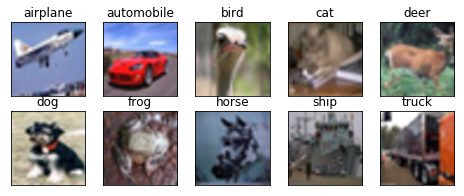

In [7]:
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(cls_train[:]==i)[0]
    features_idx = images_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::], (0, 1, 2))
    ax.set_title(class_names[i])
    plt.imshow(im, interpolation='spline16')
plt.show()

The images plotted above are smoothened but the neural network will get pixelated images. 

### Neural Network Framework

There are many open source Neural Network framework available. Also, there have been detailed comparative analysis of each of these frameworks. We have used the analysis of these studies to pick Keras with backend of Tensorflow as our framework tool for following two reasons:

1. It has better support for GPUs and multi-GPUs.
2. It's popularity in the industry and more flexibility in tuning different parameters of a network.

The entire purpose of TensorFlow is to have a so-called computational grpah that can be executed much more efficiently that if the same calculations were to be performed directly in Python. TensorFlow can be more efficient that NumPy because TF knows the entire computation graph that must be executed, while NumPy only know the computation of a single mathematical operation at a time. 

TF can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model better. This is because the graph is a combination of simple mathematical expressions so that gradient of the entire graph can be calculated using the chain-rule for derivatives. 


#### Pre-processing the Input

We pre-processes the input images. We normalize all the features. In this case, each channel at every pixel location is a feature. The range of each of these values is (0, 255). They all have same range and normlization is not required but it's a good practice to always normalize all the input features. 

Apart from this, we also convert our output labels from integers to one-hot encoding. Integer labels are used when there is an order among the different outputs. But here there is no specific order on the different classes, hence it's important to remove this inherent ordering that's enforced due to integer labels by converting them into one-hot encoding. 

In [8]:
#Normalize each channel values between 0 and 1
images_train = images_train.astype('float32')/255
images_test = images_test.astype('float32')/255
# convert class labels to binary class labels
cls_train = keras.utils.to_categorical(cls_train, num_classes)
cls_test = keras.utils.to_categorical(cls_test, num_classes)

#### Main Network

In the code below, we create the different layers of AlexNet architecture using Keras framework and connect them sequentially to create our overall network

In [9]:
# define model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

The details above shows the summary of the overall network. It shows that we have total 890,410 paramters to be tuned in our architecture. 

-----
## Performance Optimization

### Setup

My laptop computer is a Quad-core with 2.6 GHz per core. It has an Integrated GPU but not fast enough for TensorFlow so I only use CPU. It takes about ~2 mins to perform 1 epoch using the CPU on this PC. For this study, I performed 60 epochs so that took about 2 hours. 

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 145s - loss: 1.9539 - acc: 0.2829 - val_loss: 1.5574 - val_acc: 0.4288
Epoch 2/60
50000/50000 [==============================] - 138s - loss: 1.5063 - acc: 0.4523 - val_loss: 1.3230 - val_acc: 0.5201
Epoch 3/60
50000/50000 [==============================] - 136s - loss: 1.3340 - acc: 0.5196 - val_loss: 1.2221 - val_acc: 0.5599
Epoch 4/60
50000/50000 [==============================] - 142s - loss: 1.2190 - acc: 0.5664 - val_loss: 1.1620 - val_acc: 0.5887
Epoch 5/60
50000/50000 [==============================] - 136s - loss: 1.1388 - acc: 0.5977 - val_loss: 1.0874 - val_acc: 0.6150
Epoch 6/60
50000/50000 [==============================] - 137s - loss: 1.0714 - acc: 0.6221 - val_loss: 1.0108 - val_acc: 0.6461
Epoch 7/60
50000/50000 [==============================] - 136s - loss: 1.0166 - acc: 0.6429 - val_loss: 0.9401 - val_acc: 0.6722
Epoch 8/60
50000/50000 [=======================

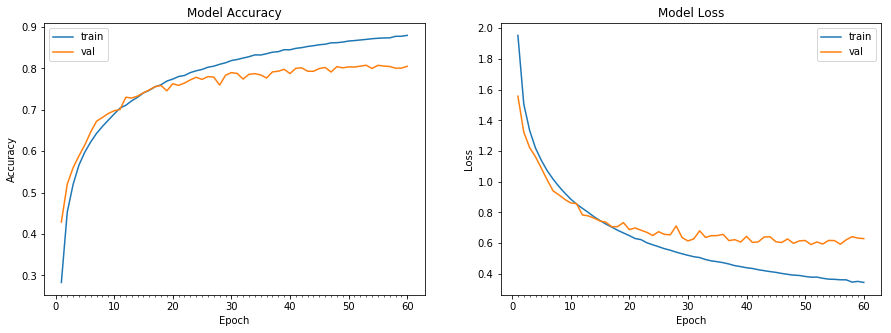

In [10]:
#Create Model checkpoing and CSV Logger
model_checkpoint = keras.callbacks.ModelCheckpoint('cifar10_weights.{epoch:02d}-{val_loss:.2f}.hdf5')
csv_logger = keras.callbacks.CSVLogger('cifar10_training.log')

batch_size = 128
epochs = 60

model1_start = time.time()
#Train the model and print out the evaluation metric 'accuracy' for test set
model_history = model.fit(images_train, cls_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = [model_checkpoint, csv_logger],
          validation_data=(images_test, cls_test))
model1_end = time.time()

print ("Model1 took %0.2f time"%(model1_end - model1_start))

plot_model_history(model_history)

The initial model even though showed a good result of ~80%. We do see that the accuracy doesn't increase after a point of 45 epochs. We did add some optimization into our model of using **Batch Normalization** before each of our Drop Out layer to learn faster. This helps in learning faster and hence is expected to give better results. We create another model (Model2) with this Batch Normalization Layer as shown below and calculate the performance on the testing set. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 64)        36928     
__________

50000/50000 [==============================] - 194s - loss: 0.2753 - acc: 0.9024 - val_loss: 0.6071 - val_acc: 0.8062
Epoch 46/60
50000/50000 [==============================] - 186s - loss: 0.2709 - acc: 0.9025 - val_loss: 0.6758 - val_acc: 0.7954
Epoch 47/60
50000/50000 [==============================] - 188s - loss: 0.2654 - acc: 0.9067 - val_loss: 0.6563 - val_acc: 0.8062
Epoch 48/60
50000/50000 [==============================] - 182s - loss: 0.2620 - acc: 0.9069 - val_loss: 0.6514 - val_acc: 0.8067
Epoch 49/60
50000/50000 [==============================] - 177s - loss: 0.2590 - acc: 0.9083 - val_loss: 0.6430 - val_acc: 0.8078
Epoch 50/60
50000/50000 [==============================] - 174s - loss: 0.2604 - acc: 0.9092 - val_loss: 0.6344 - val_acc: 0.8158
Epoch 51/60
50000/50000 [==============================] - 173s - loss: 0.2521 - acc: 0.9116 - val_loss: 0.6993 - val_acc: 0.8022
Epoch 52/60
50000/50000 [==============================] - 175s - loss: 0.2536 - acc: 0.9116 - val_los

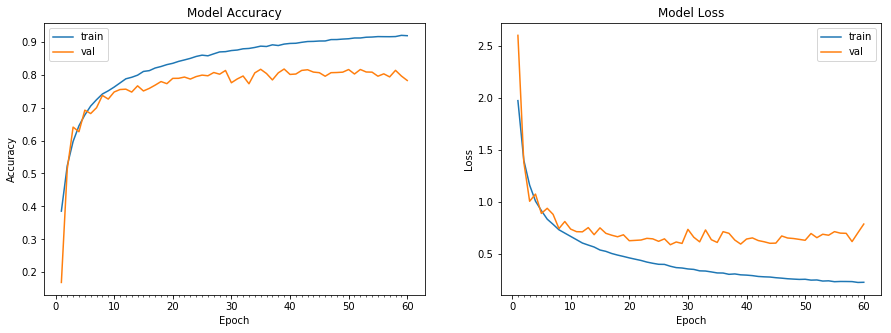

In [11]:
# define model2 with Batch Normalization
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

# compile model
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# print model summary
print(model2.summary())

model2_start = time.time()
model2_history = model2.fit(images_train, cls_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = [model_checkpoint, csv_logger],
          validation_data=(images_test, cls_test))
model2_end = time.time()
print ("Model2 took %0.2f time"%(model2_end - model2_start))

plot_model_history(model2_history)

### Results

After 60 epochs iterations, the classification accuracy is about 80% with both Model1 and Model2 on the test-set. The loss for the training set looks much lesser in Model2 than Model1 but the validation loss is higher. Even with these differences both the Model seems more or less same. But Model 2 achives this peak accuracy faster than the Model2. Model2 achieves 80% accuracy in 27 epochs but Model1 achieves 80% accuracy in 41 epochs. So, Batch Normalization helps us in learning the features faster than the model without it. Alos, with a faster GPU/CPU and more number of epochs we can achieve a higher accuracy. But keeping the hardware consraints in mind, this seems to be a good model with decent accuracy.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.